# EasyMoney EDA

## 1. Imports

### 1.1. Libraries

In [676]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import sklearn
from sklearn import set_config
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedKFold, KFold
from sklearn.metrics import accuracy_score
import category_encoders as ce

import folium
import plotly.express as px
from scipy import stats
from sklearn.tree import export_graphviz
import graphviz

set_config(transform_output = "pandas")

### 1.2. Data

In [677]:
PATH = r'C:\Users\Usuario\Desktop\Proyects\Easy Money\data_compressed'
file_name =  r"\customer_commercial_activity.csv"
file_name1 = r"\customer_products.csv"
file_name2 = r"\customer_sociodemographics.csv"
file_name3 = r"\product_description.csv"
file_name4 = r"\sales.csv"
cca = pd.read_csv(PATH + file_name, sep = ",", index_col=0)
cp = pd.read_csv(PATH + file_name1, sep = ",", index_col=0)
cs = pd.read_csv(PATH + file_name2, sep = ",", index_col=0)
prd = pd.read_csv(PATH + file_name3, sep = ",", index_col=0)
sales = pd.read_csv(PATH + file_name4, sep = ",", index_col=0)

dfs = [cca, cp, cs, sales]
_#df = df.sample(n = n_filas, random_state = 42)

,customer_category,customer_seniority
0,Single Product,Old
1,Single Product,New
2,Single Product,New
3,Single Product,Old
4,Multiple Products,Old
...,...,...
596287,Single Product,Old
596288,Multiple Products,New
596289,Multiple Products,New
596290,Single Product,Old


### 1.3. Custom Functions

In [1]:
## Data sampling

def sampling_xdf(dfs, p_sample):
    sampled_dfs = []
    for df in dfs:
        n_rows = int(len(df)*p_sample)
        sampled_df = df.sample(n = n_rows, random_state = 42)
        sampled_dfs.append(sampled_df)
    return sampled_dfs

## Preprocessing

def setOthers(dataframe, column, num_values):
    top_categories = dataframe[column].value_counts().head(num_values)
    top_categories_list = top_categories.index.to_list()
    top_categories_list.append('Others')
    dataframe[column] = pd.Categorical(dataframe[column], categories=top_categories_list)
    return dataframe[column].fillna('Others')

def categorize_customers(df, products):
    df['total_products'] = df[products].sum(axis=1)

    df['customer_category'] = 'Multiple Products'
    df.loc[df['total_products'] == 1, 'customer_category'] = 'Single Product'

    return df

def seniority(df, date_column, threshold_date):
    df[date_column] = pd.to_datetime(df[date_column])

    df['customer_seniority'] = 'Old'
    df.loc[df.groupby('pk_cid')[date_column].transform('min') >= threshold_date, 'customer_seniority'] = 'New'

    return df

## Graph

def multigraph_xyhue(x, y, hue, df, num_cols, estimator, title):
    categories = df[hue].unique()
    num_categories = len(categories)
    num_rows = -(-num_categories // num_cols)  # Round up division

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 8), sharex=True)

    for i, category in enumerate(categories):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]
        subset = df[df[hue] == category]
        sns.lineplot(x=x, y=y, data=subset, label=category, ax=ax, estimator = estimator)
        ax.set_title(category)
        ax.legend(loc='upper left')

    for i in range(num_categories, num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

    plt.suptitle(title)
    plt.tight_layout()
    return plt.show()

### 1.4. Sampling

In [679]:
cca, cp, cs, sales = sampling_xdf(dfs, 1)

cca.shape

(5962924, 6)

## 2. EDA

### 2.1. Sales / Products description

In [680]:
prd = prd.rename(columns={'pk_product_ID': 'product_ID'})
sales_prd = sales.merge(prd, on= 'product_ID', how= 'inner')
print('sales shape: ', sales.shape)
print('sales_prd shape: ', sales_prd.shape)

sales shape:  (240773, 5)
sales_prd shape:  (240773, 7)


In [681]:
min_month_sale = sales['month_sale'].min()
max_month_sale = sales['month_sale'].max()
print('first month of sale: ', min_month_sale)
print('last month of sale: ', max_month_sale)

first month of sale:  2018-02-01
last month of sale:  2019-05-01


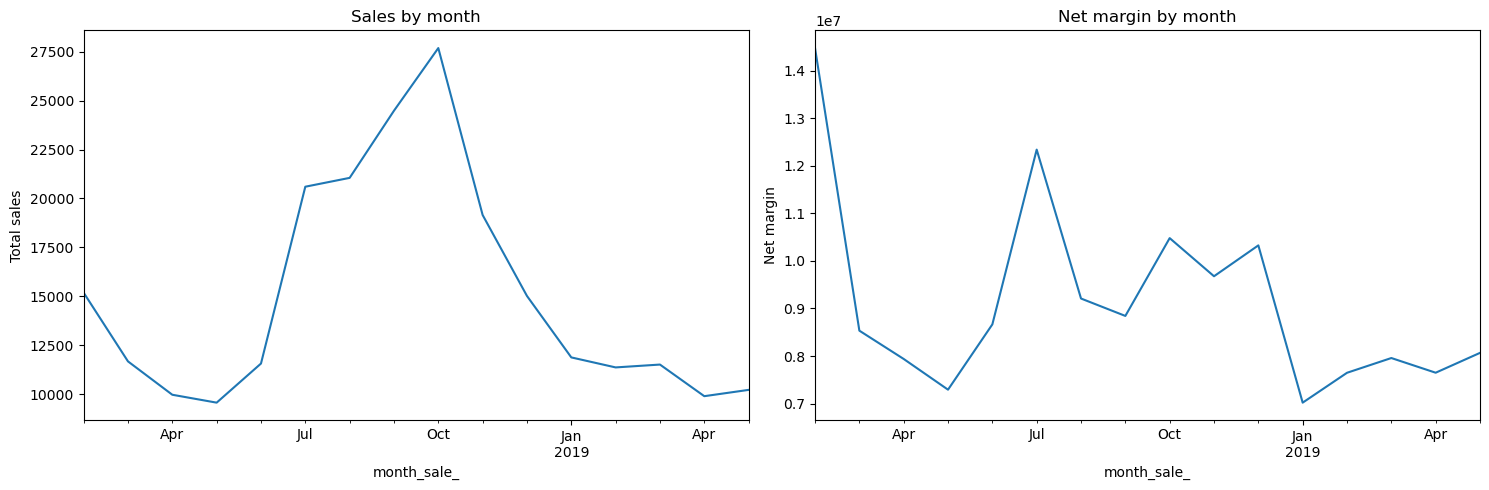

In [682]:

sales_prd['month_sale_'] = pd.to_datetime(sales_prd['month_sale'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sales_prd.set_index('month_sale_').resample('M')['pk_sale'].count().plot(ax=ax1)
ax1.set_ylabel('Total sales')
ax1.set_title('Sales by month')


sales_prd.set_index('month_sale_').resample('M')['net_margin'].sum().plot(ax=ax2)
ax2.set_ylabel('Net margin')
ax2.set_title('Net margin by month')

plt.tight_layout()

plt.show()

In [683]:
sales_agg_month = sales_prd.set_index('month_sale_').resample('M').agg({
    'pk_sale': 'count', 'net_margin': 'sum', 'product_ID': 'count'
}).rename(columns={
        'pk_sale': 'T_month_sales', 'net_margin': 'T_month_netmargin', 'product_ID': 'T_month_product_sales'
        })
sales_agg_month.head()

,T_month_sales,T_month_netmargin,T_month_product_sales
month_sale_,,,
2018-02-28,15182,14473407.7,15182
2018-03-31,11668,8533605.8,11668
2018-04-30,9962,7938591.3,9962
2018-05-31,9558,7293002.0,9558
2018-06-30,11558,8665634.3,11558


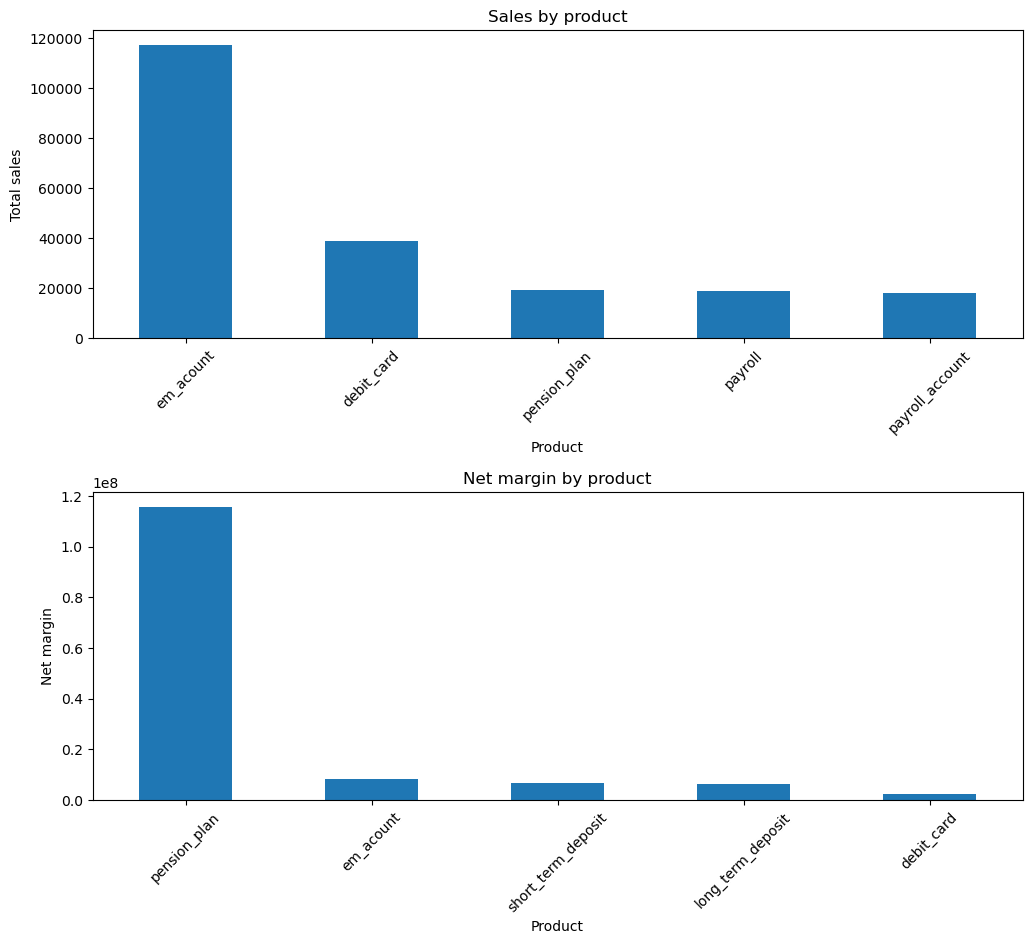

In [684]:
fig = plt.figure(figsize=(12, 10))

ax1 = plt.subplot(211)
sales_prd['product_desc'].value_counts().sort_values(ascending=False).head().plot(kind='bar')
ax1.set_xlabel('Product')
ax1.set_ylabel('Total sales')
ax1.set_title('Sales by product')
ax1.tick_params(axis='x', rotation=45)

ax2 = plt.subplot(212)
sales_prd.groupby(['product_desc'])['net_margin'].sum().sort_values(ascending=False).head().plot(kind='bar')
ax2.set_xlabel('Product')
ax2.set_ylabel('Net margin')
ax2.set_title('Net margin by product')
ax2.tick_params(axis='x', rotation=45)

plt.subplots_adjust(hspace=0.5)

plt.show()

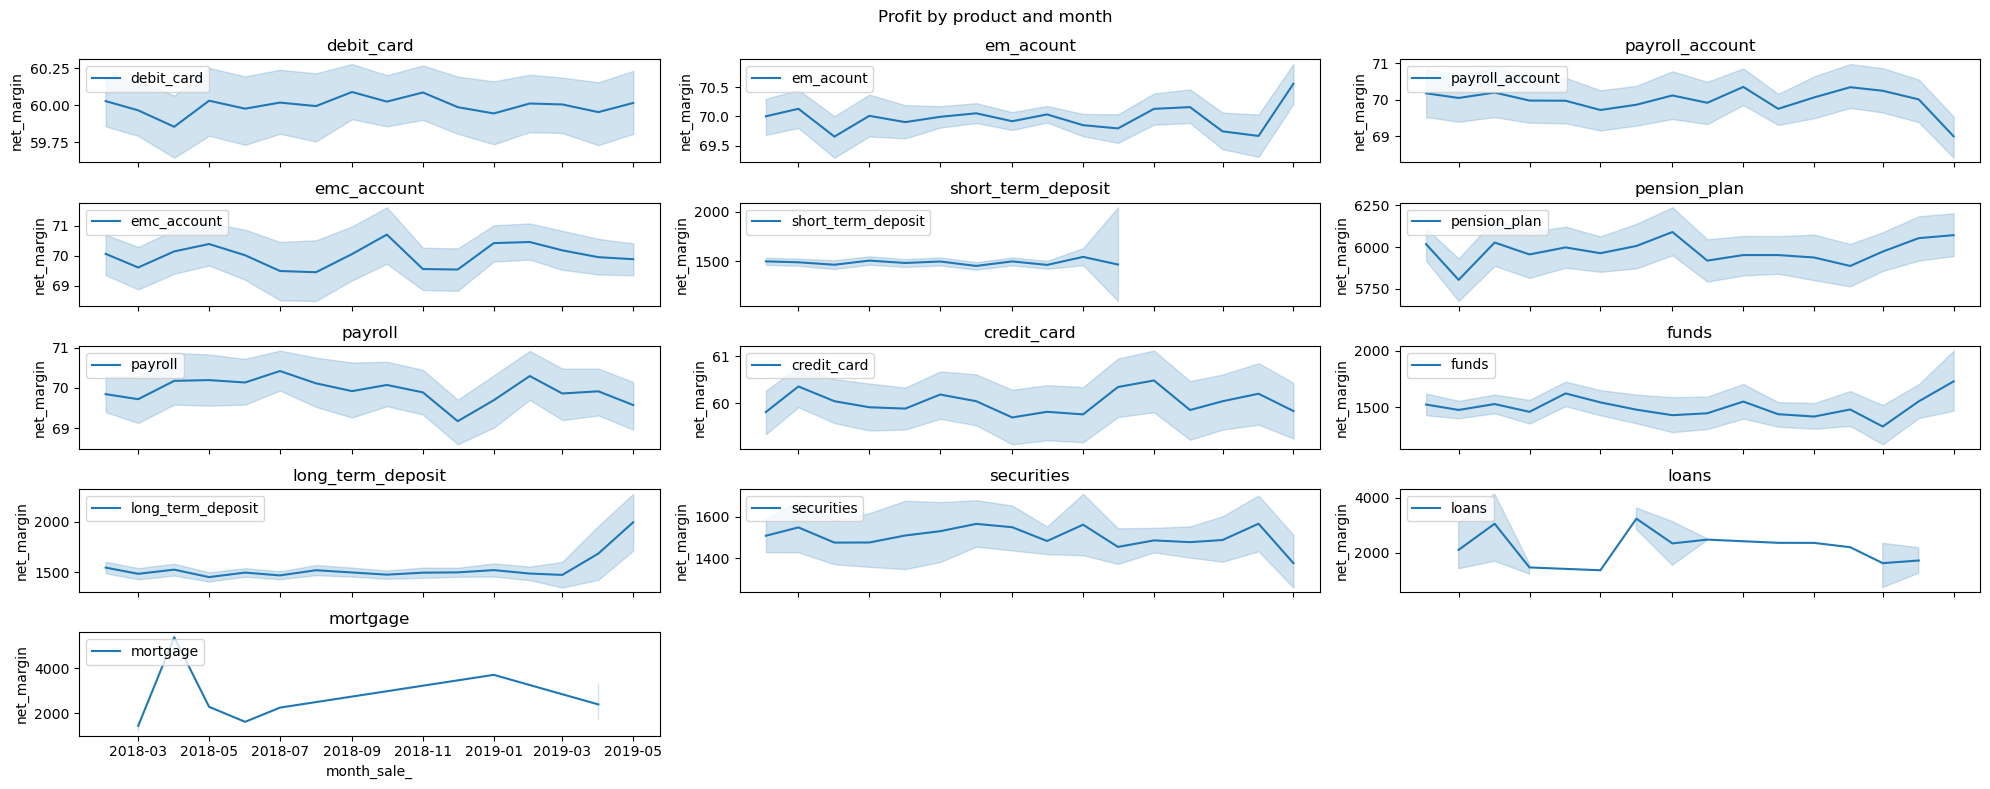

In [685]:
multigraph_xyhue('month_sale_', 'net_margin', 'product_desc', sales_prd, 3, 'mean', 'Profit by product and month')

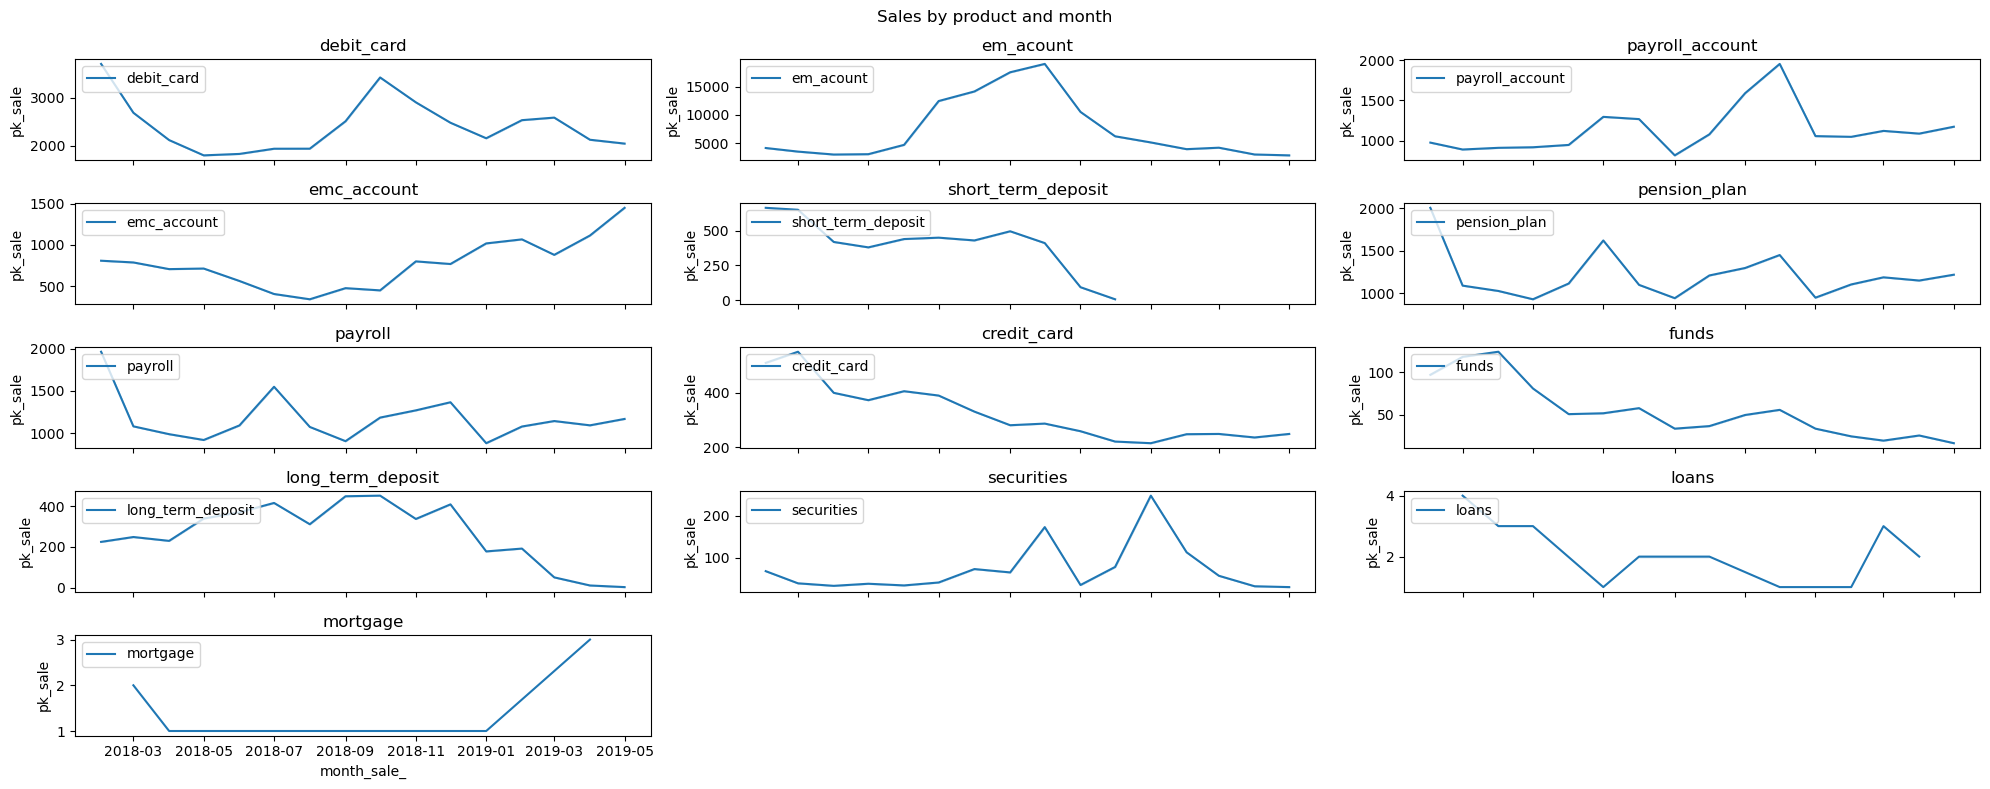

In [686]:
multigraph_xyhue('month_sale_', 'pk_sale', 'product_desc', sales_prd, 3, lambda x: len(x),'Sales by product and month')

### 2.2. Customers

In [687]:
def cust_prep_(cca, cs):
    cust = cca.merge(cs, on = ['pk_cid', 'pk_partition'], how = 'inner').merge(cp, on = ['pk_cid', 'pk_partition'], how = 'inner')
    cust = cust[cust['deceased']== 'N'].drop('deceased', axis =  1)
    cust_es = pd.DataFrame(cust[cust['country_id'] == 'ES'].drop('country_id', axis = 1))
    cust_es[['region_code', 'gender', 'payroll', 'pension_plan']] = SimpleImputer(strategy =  'most_frequent').fit_transform(
        cust_es[['region_code', 'gender', 'payroll', 'pension_plan']])
    cust_es['segment'] = SimpleImputer(strategy =  'constant', fill_value = 'Others').fit_transform(
        cust_es[['segment']])
    sal_mn_regage = cust_es.groupby(['age', 'region_code'])['salary'].transform('mean')
    cust_es['salary_imp'] = cust_es['salary'].fillna(sal_mn_regage).round(2)
    cust_es['salary_imp'] = SimpleImputer(strategy = 'mean').fit_transform(cust_es[['salary_imp']])
    cust_es['entry_channel'] = setOthers(cust_es, 'entry_channel', 10)
    cust_es['region_code'] = setOthers(cust_es, 'region_code', 40)
    return cust_es

cust_es = cust_prep_(cca, cs)

#### 2.2.1. Univariant Analysis

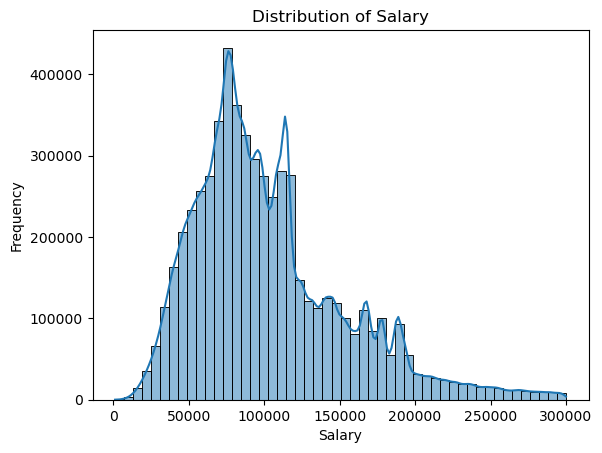

In [688]:
salary_gen = cust_es[cust_es['salary_imp'] <= 300000]

sns.histplot(data=salary_gen, x='salary_imp', bins = 50, kde=True)
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.title('Distribution of Salary')
plt.show()

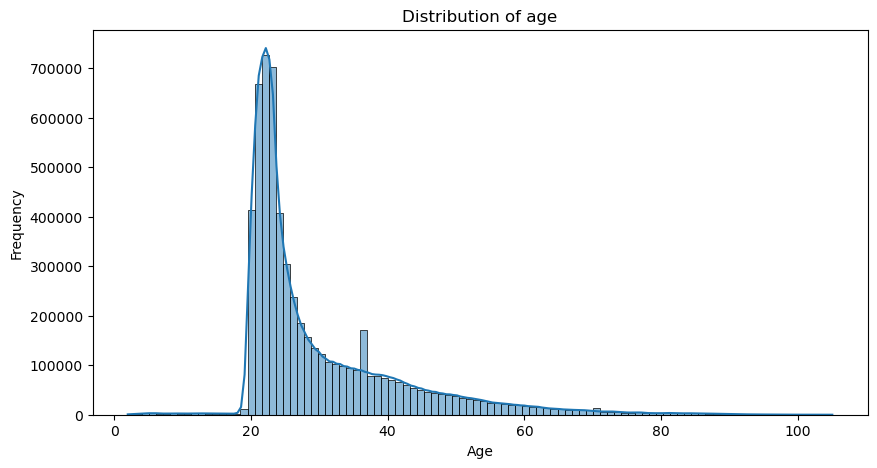

In [689]:
plt.figure(figsize= [10, 5])

sns.histplot(data=cust_es, x='age', bins = 100, kde=True)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of age')
plt.show()

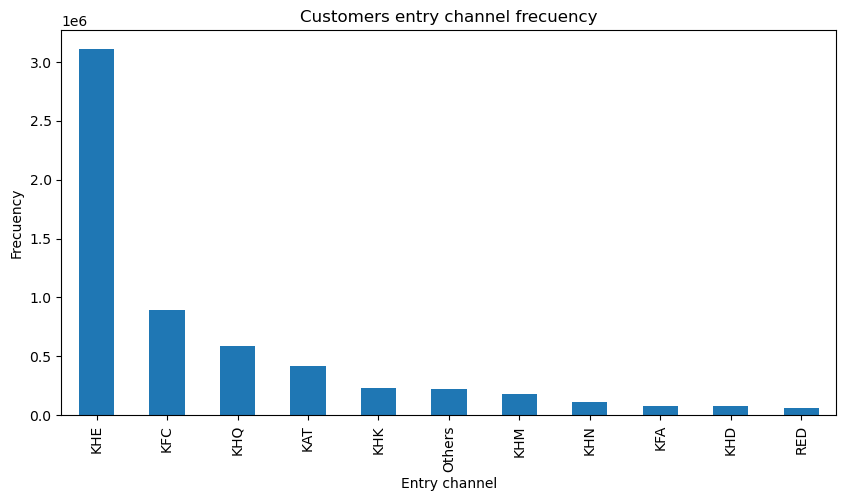

In [690]:
plt.figure(figsize= [10, 5])
cust_es['entry_channel'].value_counts().plot(kind = 'bar')
plt.xlabel('Entry channel')
plt.ylabel('Frecuency')
plt.title('Customers entry channel frecuency')
plt.show()

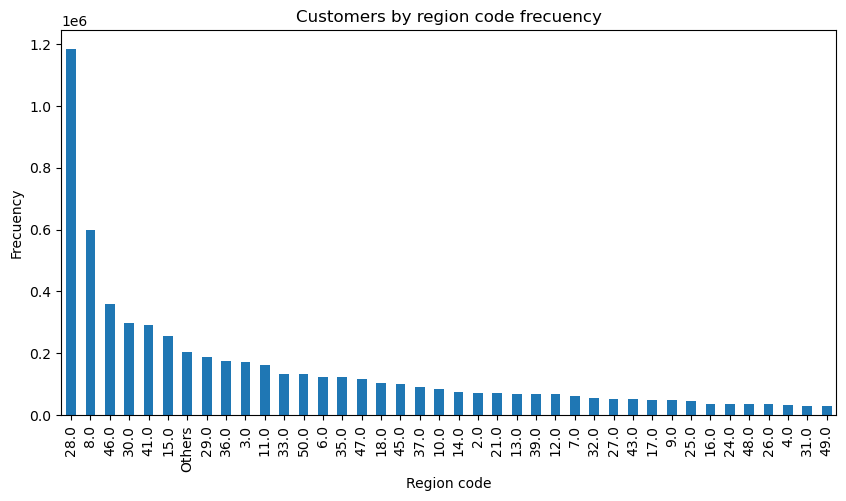

In [691]:
plt.figure(figsize= [10, 5])
cust_es['region_code'].value_counts().head(40).plot(kind = 'bar')
plt.xlabel('Region code')
plt.ylabel('Frecuency')
plt.title('Customers by region code frecuency')
plt.show()

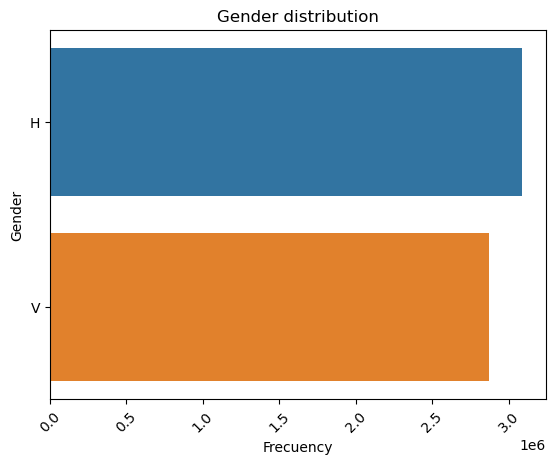

In [692]:
gender_counts = cust_es['gender'].value_counts()
sns.barplot(y=gender_counts.index, x=gender_counts.values)
plt.xticks(rotation=45)
plt.xlabel('Frecuency')
plt.ylabel('Gender')
plt.title('Gender distribution')
plt.show()

#### 2.2.2. Bivariant analysis

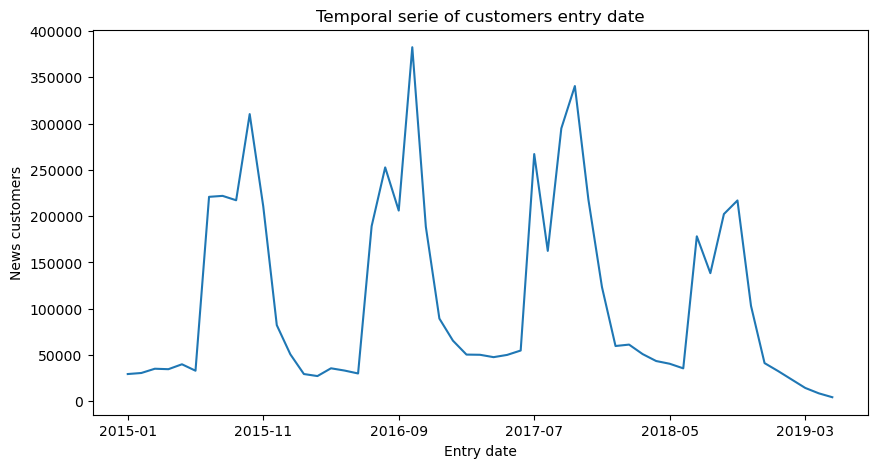

In [693]:
plt.figure(figsize= [10, 5])
cust_es.groupby('entry_date')['pk_cid'].count().plot()
plt.xlabel('Entry date')
plt.ylabel('News customers')
plt.title('Temporal serie of customers entry date')
plt.show()

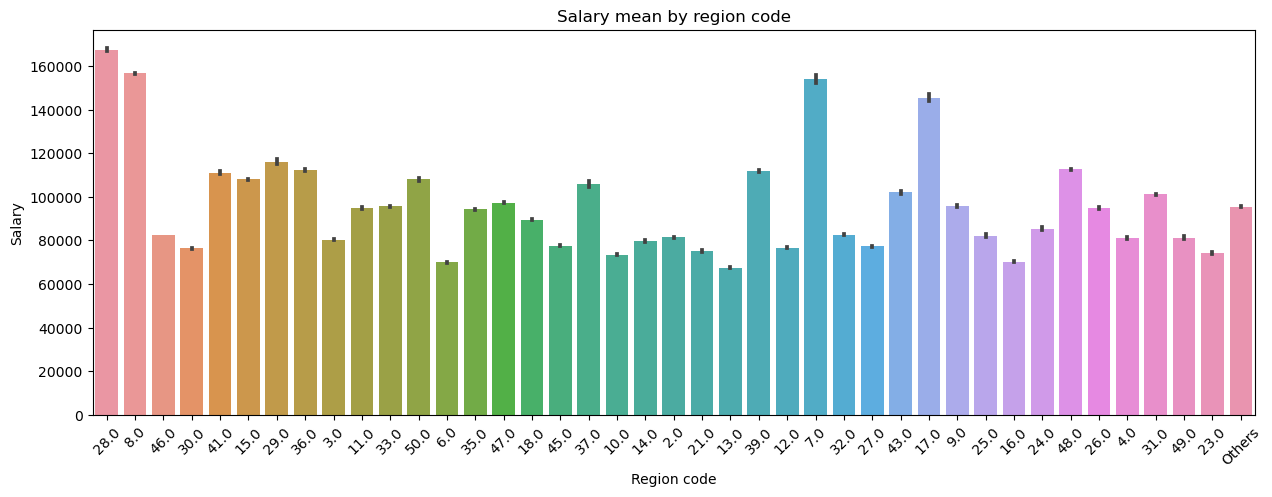

In [694]:
plt.figure(figsize= [15, 5])

sns.barplot(x='region_code', y='salary_imp', data = cust_es)
plt.xticks(rotation=45)
plt.xlabel('Region code')
plt.ylabel('Salary')
plt.title('Salary mean by region code')
plt.show()


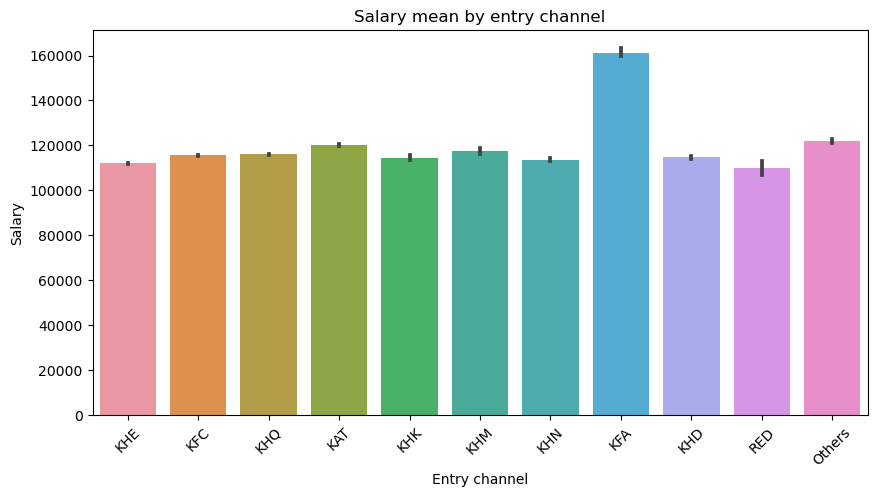

In [695]:
plt.figure(figsize= [10, 5])

sns.barplot(x='entry_channel', y='salary_imp', data = cust_es)
plt.xticks(rotation=45)
plt.xlabel('Entry channel')
plt.ylabel('Salary')
plt.title('Salary mean by entry channel')
plt.show()

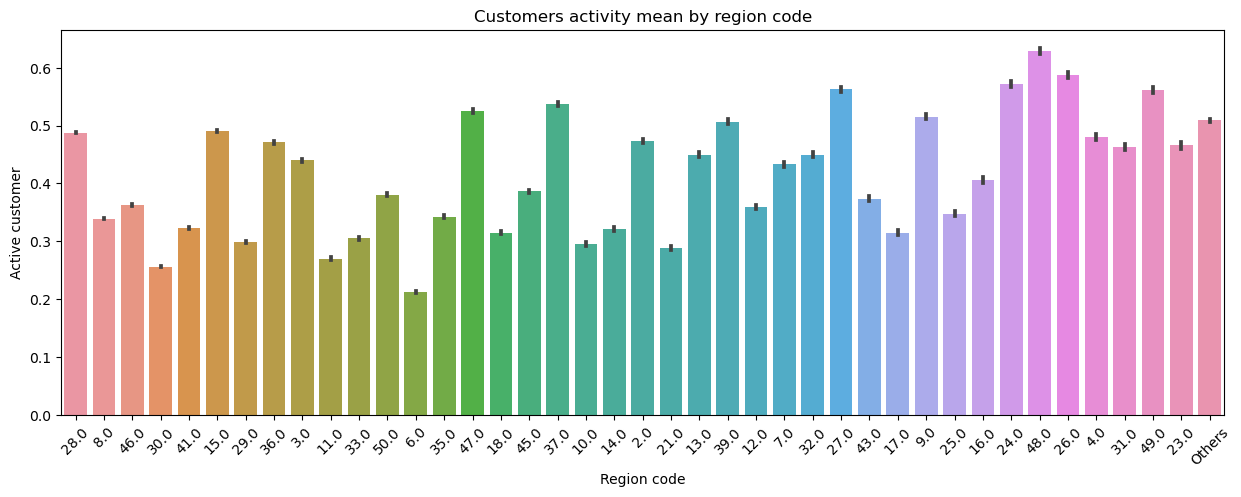

In [696]:
plt.figure(figsize= [15, 5])

sns.barplot(x='region_code', y='active_customer', data = cust_es)
plt.xticks(rotation=45)
plt.xlabel('Region code')
plt.ylabel('Active customer')
plt.title('Customers activity mean by region code')
plt.show()



In [697]:
cust_es.columns

Index(['pk_cid', 'pk_partition', 'entry_date', 'entry_channel',
       'active_customer', 'segment', 'region_code', 'gender', 'age', 'salary',
       'short_term_deposit', 'loans', 'mortgage', 'funds', 'securities',
       'long_term_deposit', 'em_account_pp', 'credit_card', 'payroll',
       'pension_plan', 'payroll_account', 'emc_account', 'debit_card',
       'em_account_p', 'em_acount', 'salary_imp'],
      dtype='object')

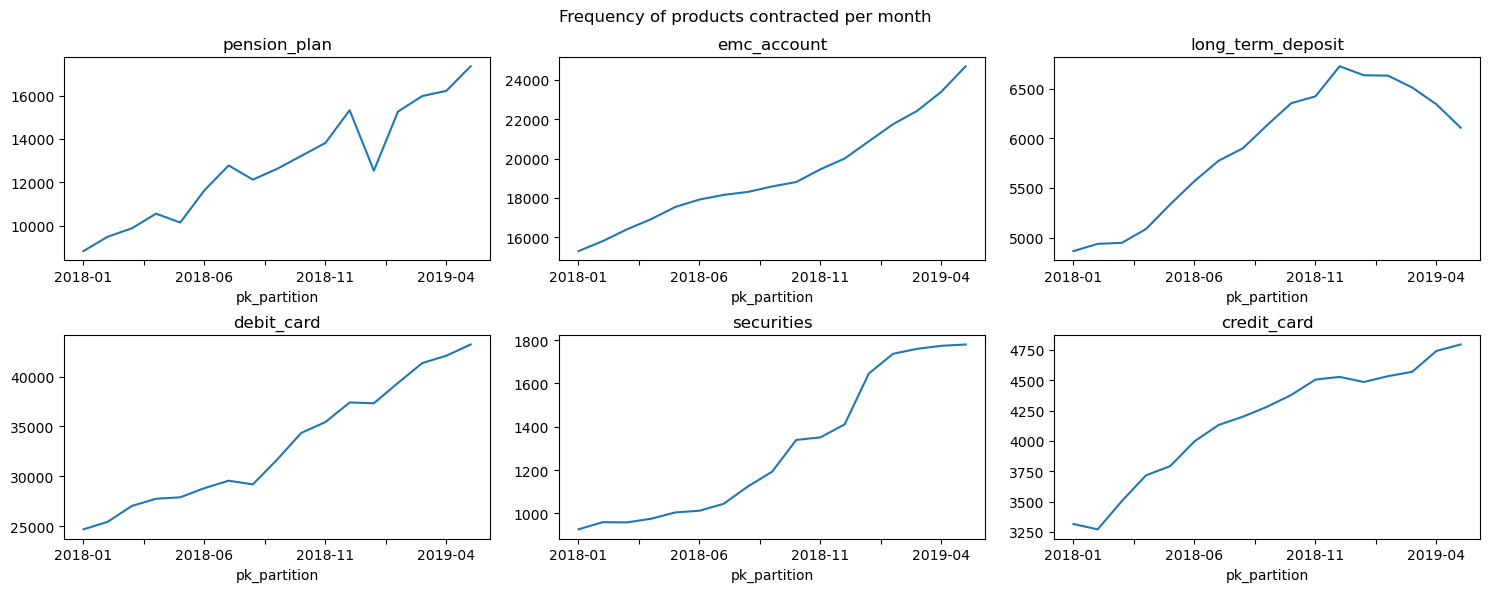

In [698]:
variables = ['pension_plan', 'emc_account', 'long_term_deposit', 'debit_card', 'securities', 'credit_card']

fig, axes = plt.subplots(2, 3, figsize=(15, 6))

for i, variable in enumerate(variables):
    row = i // 3
    col = i % 3
    cust_es.groupby('pk_partition')[variable].sum().plot(ax=axes[row, col])
    axes[row, col].set_title(variable)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle('Frequency of products contracted per month')

plt.show()

In [699]:
cust_es.columns

Index(['pk_cid', 'pk_partition', 'entry_date', 'entry_channel',
       'active_customer', 'segment', 'region_code', 'gender', 'age', 'salary',
       'short_term_deposit', 'loans', 'mortgage', 'funds', 'securities',
       'long_term_deposit', 'em_account_pp', 'credit_card', 'payroll',
       'pension_plan', 'payroll_account', 'emc_account', 'debit_card',
       'em_account_p', 'em_acount', 'salary_imp'],
      dtype='object')

In [700]:
products = ['short_term_deposit', 'loans', 'mortgage', 'funds', 'securities',
       'long_term_deposit', 'em_account_pp', 'credit_card', 'payroll',
       'pension_plan', 'payroll_account', 'emc_account', 'debit_card',
       'em_account_p', 'em_acount']



cust_es = categorize_customers(cust_es, products)

<Figure size 1200x600 with 0 Axes>

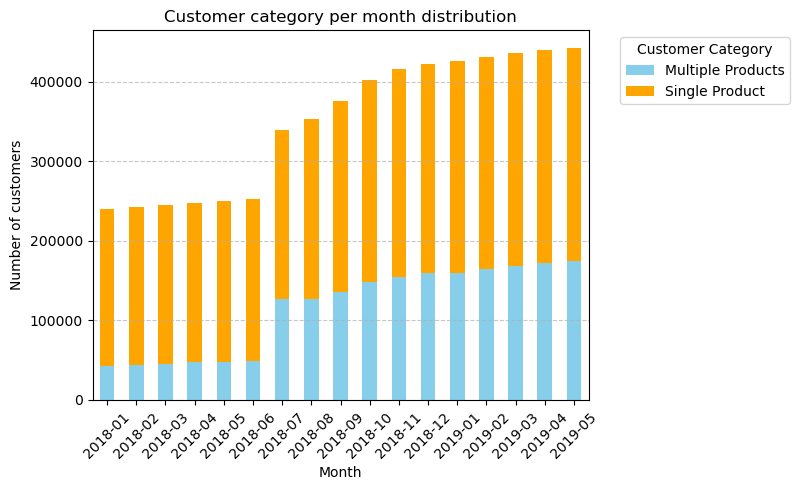

In [701]:
cust_cat_distr = cust_es.groupby(['pk_partition', 'customer_category']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
cust_cat_distr.plot(kind='bar', stacked=True, color=['skyblue', 'orange'])
plt.title('Customer category per month distribution')
plt.xlabel('Month')
plt.ylabel('Number of customers')
plt.xticks(rotation=45)
plt.legend(title='Customer Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [702]:
threshold_date = pd.to_datetime('2018-01-01')

cust_es = seniority(cust_es, 'entry_date', threshold_date)

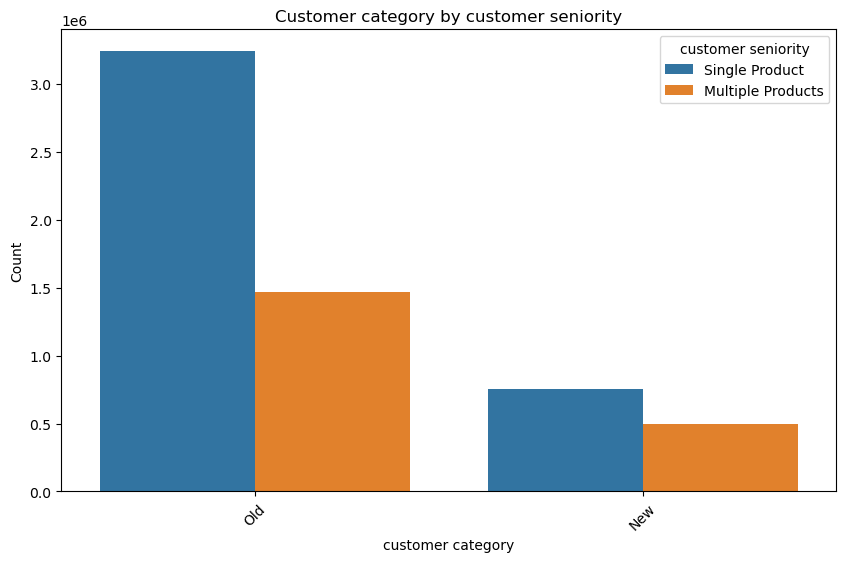

In [703]:
plt.figure(figsize=(10, 6))
sns.countplot(data=cust_es, x='customer_seniority', hue='customer_category')
plt.title('Customer category by customer seniority')
plt.xlabel('customer category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='customer seniority')
plt.show()

In [704]:
contingency_table = pd.crosstab(index=cust_es['customer_seniority'], columns=cust_es['customer_category'], normalize='index') * 100

print("Contigency table:")
print(contingency_table)

Contigency table:
customer_category   Multiple Products  Single Product
customer_seniority                                   
New                         39.842799       60.157201
Old                         31.145481       68.854519


In [705]:
cust_es.to_csv('C:/Users/Usuario/Desktop/Proyects/Easy Money/EasyMoney_/CSVs/customers_ES.csv')
sales_prd.to_csv('C:/Users/Usuario/Desktop/Proyects/Easy Money/EasyMoney_/CSVs/sales_products.csv')